[I 2024-08-04 14:53:37,312] A new study created in memory with name: no-name-a654023a-dd5c-49a0-b88a-f78d2db0f323
[I 2024-08-04 14:54:10,939] Trial 0 finished with value: 0.8634392227577798 and parameters: {'n_estimators': 384, 'max_depth': 7, 'learning_rate': 7.11684965703502e-05, 'subsample': 0.5506660212935979, 'colsample_bytree': 0.7357899138865824, 'min_child_weight': 9, 'max_delta_step': 7, 'gamma': 0.004321479508583865, 'reg_alpha': 0.0007584851044613259, 'reg_lambda': 3.3352908427342607, 'tweedie_variance_power': 1.7600257081007282}. Best is trial 0 with value: 0.8634392227577798.
[I 2024-08-04 14:55:03,935] Trial 1 finished with value: 0.8847621348853768 and parameters: {'n_estimators': 251, 'max_depth': 10, 'learning_rate': 2.0744714641247817e-05, 'subsample': 0.8684254369231726, 'colsample_bytree': 0.8980313858507553, 'min_child_weight': 1, 'max_delta_step': 10, 'gamma': 0.0007023489213288983, 'reg_alpha': 7.267016410079039e-05, 'reg_lambda': 1.3013668060604218, 'tweedie_var


Model Performance
Test MSE: 26.095591849324354
Test RMSE: 5.108384465692099
Test MAE: 1.047879751023772
Test R² Score: 0.723730206489563


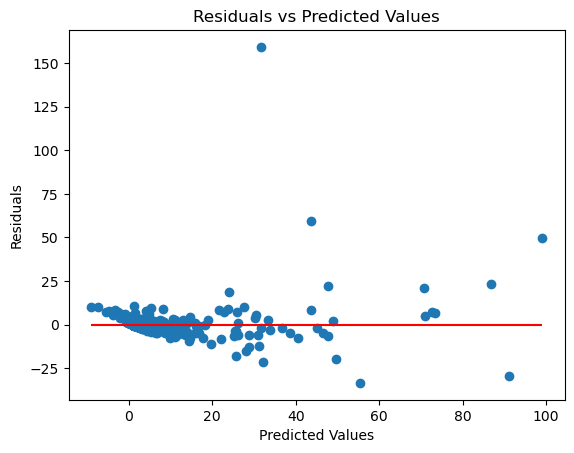

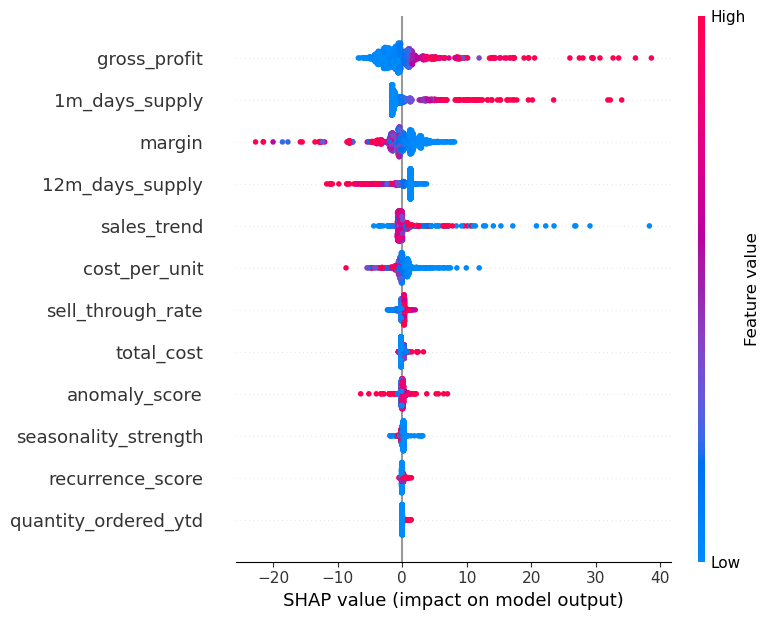

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import optuna
from joblib import parallel_backend
import joblib
import numpy as np
import json
import shap
from math import sqrt

# Load data
df = pd.read_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/parts_data_prepared.csv')

# Define feature columns and target variable
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_revenue', 'cogs', 'price', 'rolling_12m_sales',
                                                         'quantity', 'price', 'rolling_3m_sales', 'days_of_inventory_outstanding',
                                                         'months_no_sale', 'recent_sales_trend', 'negative_on_hand', 'sales_volatility',
                                                         '3m_turnover', '3m_days_supply', 'margin_percentage'
                                                         }]

mask = df['months_no_sale'] >=12                          
X = df[~mask][feature_cols]
y = df[~mask]['rolling_12m_sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Define preprocessing pipeline
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', MinMaxScaler())]),
        numerical_features)
    ])

# Set up KFold cross-validation
kf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

def rmsle(y_true, y_pred, epsilon=1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Check for negative values in predictions
    if np.any(y_pred < 0):
        print(f"Warning: {np.sum(y_pred < 0)} negative predictions found. Clipping to {epsilon}.")
    
    # Check for zero values in predictions
    if np.any(y_pred == 0):
        print(f"Warning: {np.sum(y_pred == 0)} zero predictions found. Adding {epsilon}.")
    
    # Clip predictions to be positive
    y_pred = np.maximum(y_pred, epsilon)
    
    # Calculate RMSLE
    return sqrt(mean_squared_log_error(y_true, y_pred))

scorer = make_scorer(rmsle, greater_is_better=False)

scorer = make_scorer(rmsle, greater_is_better=False)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'reg:tweedie',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 5.0, log=True),
        "reg_lambda": trial.suggest_float('reg_lambda', 1e-5, 5.0, log=True),
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9)
    }
    # Define the model
    model = XGBRegressor(**params, base_score=np.mean(y_train))
    
    # Define the full pipeline without RFECV
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    try:
        with parallel_backend('threading'):
            scores = cross_val_score(pipeline, X_train, y_train, scoring=scorer, cv=kf)
        return -scores.mean()
    except Exception as e:
        print(f"Error in objective function: {str(e)}")
        # You might want to return a large value here to indicate a failed trial
        return 1e10


# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials= 500)

best_hyperparams = study.best_params

# Train the model with the best hyperparameters
final_model = XGBRegressor(**best_hyperparams)


# Perform feature selection with RFECV using the optimal hyperparameters
rfecv = RFECV(estimator=final_model, step=1, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

# Define the final pipeline with RFECV and optimal hyperparameters
feature_selection_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', rfecv)
])

# Fit the feature selection pipeline
feature_selection_pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[feature_selection_pipeline.named_steps['feature_selector'].support_]

# Define the final preprocessor for selected features
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', MinMaxScaler())
        ]), selected_features)
    ]
)

# Define the final model pipeline with selected features
final_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('regressor', final_model)
])

# Fit the final pipeline on the selected features
final_pipeline.fit(X_train[selected_features], y_train)

# Save the selected features and the best hyperparameters to a JSON file
results_dict = {
    "selected_features": selected_features.tolist(),
    "best_hyperparameters": best_hyperparams
}

with open('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/general_model_details.json', 'w') as fp:
    json.dump(results_dict, fp, indent=4)

# Save the final pipeline for application
joblib.dump(final_pipeline, '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/xgb_regressor_with_selected_features.joblib')

# Evaluate the model
X_test_transformed = final_pipeline.named_steps['preprocessor'].transform(X_test[selected_features])
y_pred = final_pipeline.named_steps['regressor'].predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nModel Performance')
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R² Score: {r2}")

# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# SHAP analysis
explainer = shap.Explainer(final_model, X_test_transformed)
shap_values = explainer(X_test_transformed)

# Optionally, you can visualize the SHAP values
shap.summary_plot(shap_values, X_test_transformed, feature_names=selected_features)

# Save SHAP values
shap_df = pd.DataFrame(shap_values.values, columns=selected_features)
shap_df.to_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/shap_values.csv', index=False)



In [10]:
# Load the hyperparameters from the JSON file
with open('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/general_model_details.json', 'r') as file:
    hyperparameters = json.load(file)

# Print the hyperparameters
print("Hyperparameters saved in the JSON file:")
print(hyperparameters)

Hyperparameters saved in the JSON file:
{'selected_features': ['margin', 'quantity_ordered_ytd', 'cost_per_unit', 'total_cost', 'gross_profit', 'seasonality_strength', 'anomaly_score', 'recurrence_score', '12m_days_supply', '1m_days_supply', 'sell_through_rate', 'sales_trend'], 'best_hyperparameters': {'n_estimators': 490, 'max_depth': 5, 'learning_rate': 0.0796252230188944, 'subsample': 0.6412153904772979, 'colsample_bytree': 0.9978228786586596, 'min_child_weight': 9, 'max_delta_step': 4, 'gamma': 0.0003276021813710634, 'reg_alpha': 5.706041275112271e-05, 'reg_lambda': 0.009134733108734593, 'tweedie_variance_power': 1.8834344958111788}}


In [39]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Load the data
df = pd.read_csv("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/parts_data_prepared.csv")

# Select the features (X) and target (y) for modeling
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_revenue', 'cogs', 'price', 'rolling_12m_sales',
                                                         'quantity', 'price', 'rolling_3m_sales', 'days_of_inventory_outstanding',
                                                         'months_no_sale', 'recent_sales_trend', 'negative_on_hand', 'sales_volatility',
                                                         '3m_turnover', '3m_days_supply', 'margin_percentage'
                                                         }]
X = df[feature_cols]
print(X.shape)

# Add a constant to the DataFrame
df = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display the VIF for each feature
print(vif_data)


(16228, 17)
                 feature       VIF
0                  const  2.509136
1                 margin  3.140953
2     special_orders_ytd  1.047500
3   quantity_ordered_ytd  1.073453
4          cost_per_unit  2.897979
5             total_cost  1.204860
6           gross_profit  1.283540
7                    roi  1.003538
8   seasonality_strength  1.625396
9            consistency  2.845145
10         anomaly_score  3.190219
11      recurrence_score  1.657899
12       12m_days_supply  1.601400
13        1m_days_supply  1.648358
14              turnover  1.020817
15     sell_through_rate  1.410446
16  order_to_sales_ratio  1.057068
17           sales_trend  1.098044


In [5]:
# For a pandas Series
has_negative_or_zero = (y <= 0).any()
count_negative_or_zero = (y <= 0).sum()
percent_negative_or_zero = (y <= 0).mean() * 100

print(f"Contains negative or zero values: {has_negative_or_zero}")
print(f"Number of negative or zero values: {count_negative_or_zero}")
print(f"Percentage of negative or zero values: {percent_negative_or_zero:.2f}%")

# Show the negative or zero values
print("Negative or zero values:")
print(y[y <= 0])

Contains negative or zero values: False
Number of negative or zero values: 0
Percentage of negative or zero values: 0.00%
Negative or zero values:
Series([], Name: rolling_12m_sales, dtype: int64)


In [17]:
import polars as pl

df = pd.read_csv("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/parts_data_prepared.csv")

# Select the features (X) and target (y) for modeling
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_revenue', 'cogs', 'price', 'rolling_12m_sales',
                                                         }]
X = df[feature_cols]


X.isna().sum()



months_no_sale                   0
margin                           0
special_orders_ytd               0
negative_on_hand                 0
quantity                         0
quantity_ordered_ytd             0
cost_per_unit                    0
total_cost                       0
margin_percentage                0
gross_profit                     0
roi                              0
seasonality_strength             0
consistency                      0
anomaly_score                    0
recurrence_score                 0
rolling_3m_sales                 0
12m_days_supply                  0
3m_days_supply                   0
1m_days_supply                   0
turnover                         0
3m_turnover                      0
sell_through_rate                0
days_of_inventory_outstanding    0
order_to_sales_ratio             0
sales_trend                      0
sales_volatility                 0
recent_sales_trend               0
dtype: int64

In [5]:
import joblib
import json
import logging

# Define file paths
PREPROCESSOR_PATH = '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/preprocessor.joblib'
MODEL_PATH = '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/xgb_regressor_with_selected_features.joblib'
MODEL_INFO_PATH = '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/general_model_details.json'

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

def print_preprocessor_details(preprocessor_path):
    try:
        preprocessor = joblib.load(preprocessor_path)
        logging.info("Preprocessor loaded successfully.")
        print("Preprocessor Structure:")
        print(preprocessor)
    except Exception as e:
        logging.error(f"Failed to load preprocessor: {e}")

def print_model_details(model_path):
    try:
        model = joblib.load(model_path)
        logging.info("Model loaded successfully.")
        print("Model Details:")
        print(model)
        print("Feature Importances (if available):")
        print(getattr(model, 'feature_importances_', 'Not available'))
    except Exception as e:
        logging.error(f"Failed to load model: {e}")

def print_json_configuration(model_info_path):
    try:
        with open(model_info_path, 'r') as file:
            model_info = json.load(file)
        logging.info("Model configuration loaded successfully.")
        print("Model Configuration:")
        print(json.dumps(model_info, indent=4))
    except Exception as e:
        logging.error(f"Failed to load model configuration JSON: {e}")

def main():
    print_preprocessor_details(PREPROCESSOR_PATH)
    print_model_details(MODEL_PATH)
    print_json_configuration(MODEL_INFO_PATH)

if __name__ == "__main__":
    main()


2024-07-19 17:37:10,558 - Preprocessor loaded successfully.
2024-07-19 17:37:10,596 - Model loaded successfully.
2024-07-19 17:37:10,613 - Model configuration loaded successfully.


Preprocessor Structure:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('power_trans',
                                                  PowerTransformer())]),
                                 Index(['normalized_seasonal_score', 'negative_on_hand', 'quantity_ordered_ytd',
       'special_orders_ytd', 'total_cost', 'margin_percentage', 'gross_profit',
       'roi', '12m_days_supply', '3m_days_supply', '1m_days_supply',
       'turnover', '3m_turnover', 'sell_through_rate',
       'days_of_inventory_outstanding', 'order_to_sales_ratio'],
      dtype='object'))])
Model Details:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                